#Import Libraries

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns



#Simulate Date (Rainfall and Gross product per hectare (GPha))

In [23]:
np.random.seed(42)
years = [f'Y{i:2}' for i in range(1, 11)]
crops = ['Maize', 'Cowpea', 'Rice', 'Cassava', 'Spinach']
simulations = 1000

rainfall = np.random.normal(loc=500, scale=80, size=10)
gpha_data = {'Rainfall': rainfall}
for crop in crops:
    slope = np.random.uniform(5, 15)
    intercept = np.random.uniform(500, 2000)
    noise = np.random.normal(0, 300, size=10)
    gpha_data[crop] = intercept + slope * rainfall + noise
simulated = pd.DataFrame(gpha_data, index=years)


#Regression Models

In [24]:
models = {}
stderr_preds = {}
for crop in crops:
    X = sm.add_constant(simulated[['Rainfall']])
    y = simulated[crop]
    model = sm.OLS(y, X).fit()
    models[crop] = model
    pred_var = model.mse_resid + np.dot(X, np.dot(model.cov_params(), X.T)).diagonal()
    stderr_preds[crop] = np.sqrt(pred_var)

#Scatter + Regression Line

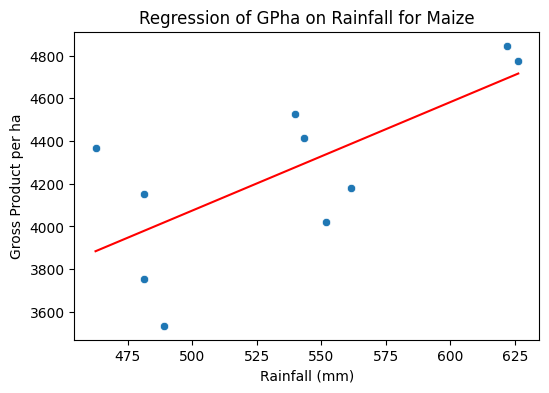

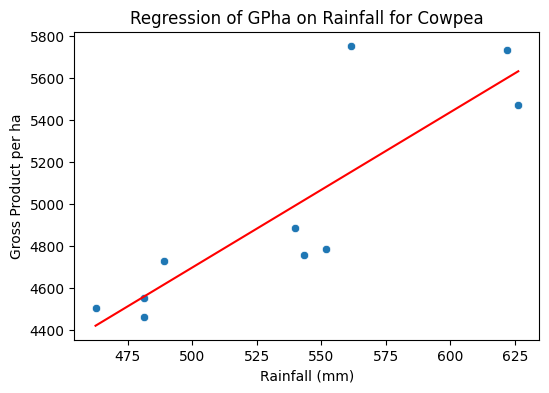

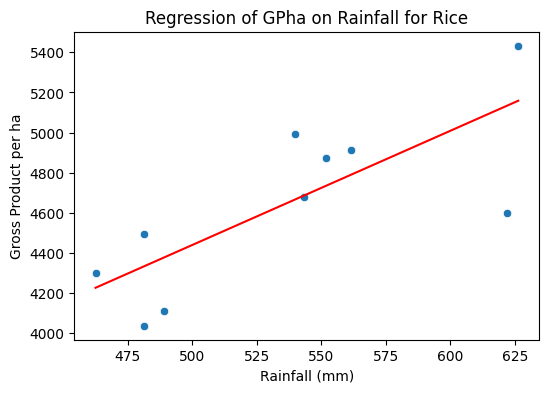

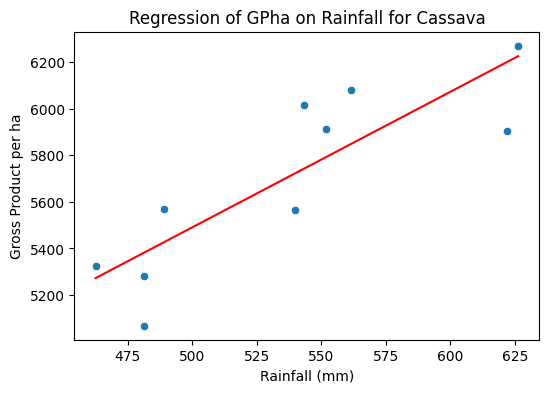

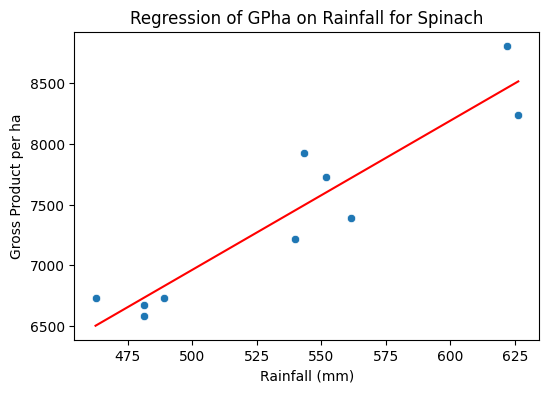

In [25]:
for crop in crops:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=simulated['Rainfall'], y=simulated[crop])
    X_plot = sm.add_constant(np.linspace(simulated['Rainfall'].min(), simulated['Rainfall'].max(), 100))
    y_plot = models[crop].predict(X_plot)
    plt.plot(X_plot[:,1], y_plot, color='red')
    plt.title(f'Regression of GPha on Rainfall for {crop}')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Gross Product per ha')
    plt.show()


#Confidence Intervals

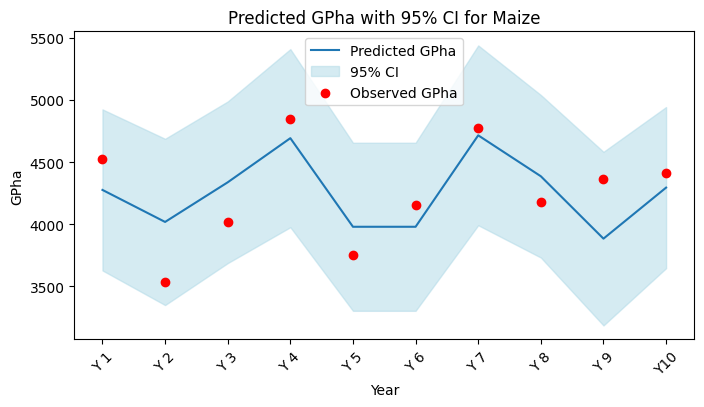

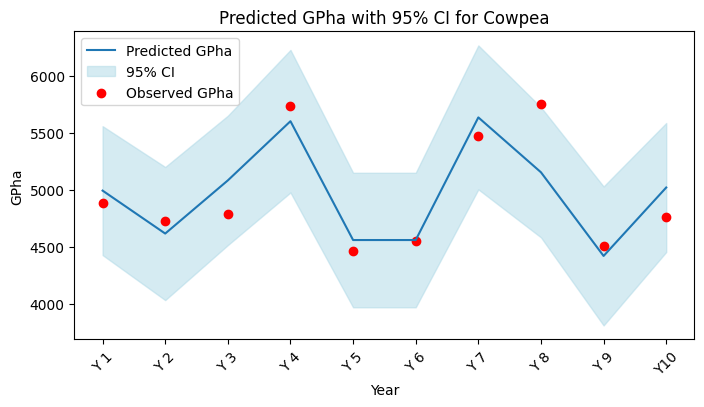

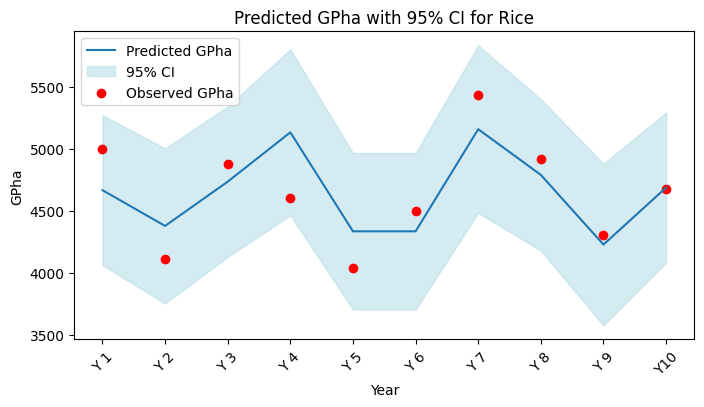

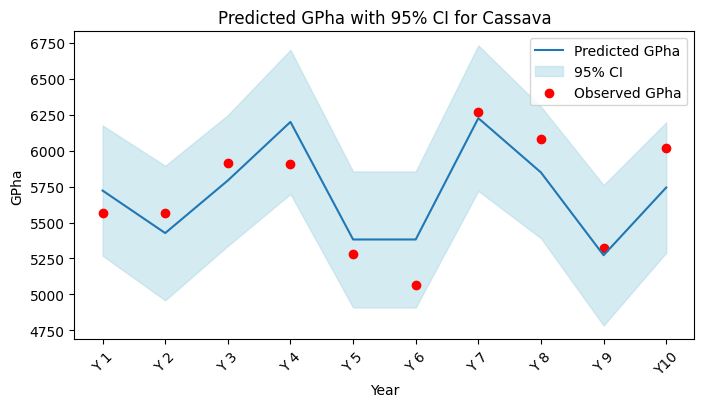

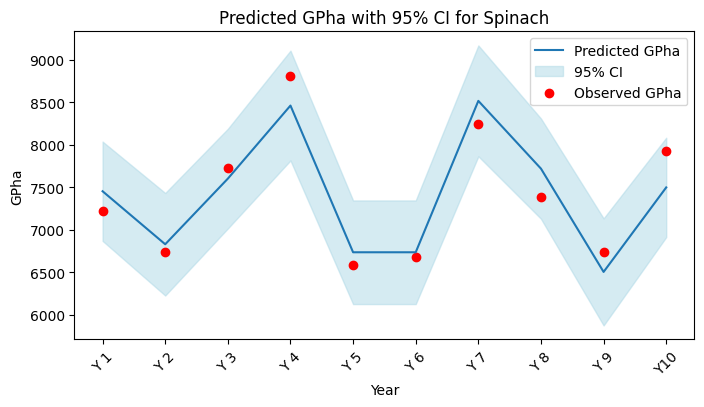

In [26]:
for crop in crops:
    plt.figure(figsize=(8,4))
    pred_mean = models[crop].predict(sm.add_constant(simulated[['Rainfall']]))
    ci_lower = pred_mean - 1.96 * stderr_preds[crop]
    ci_upper = pred_mean + 1.96 * stderr_preds[crop]
    plt.plot(years, pred_mean, label='Predicted GPha')
    plt.fill_between(years, ci_lower, ci_upper, color='lightblue', alpha=0.5, label='95% CI')
    plt.scatter(years, simulated[crop], label='Observed GPha', color='red')
    plt.title(f'Predicted GPha with 95% CI for {crop}')
    plt.ylabel('GPha')
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

#Monte Carlo Simulation

In [27]:
sim_gp = {crop: [] for crop in crops}
for _ in range(simulations):
    rain_sim = np.random.normal(loc=rainfall.mean(), scale=rainfall.std())
    for crop in crops:
        intercept = models[crop].params['const']
        slope = models[crop].params['Rainfall']
        noise = np.random.normal(0, stderr_preds[crop].mean())
        sim_value = intercept + slope * rain_sim + noise
        sim_gp[crop].append(sim_value)

#Histogram of Simulation

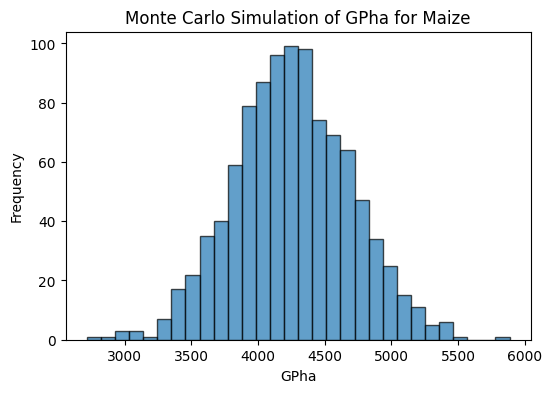

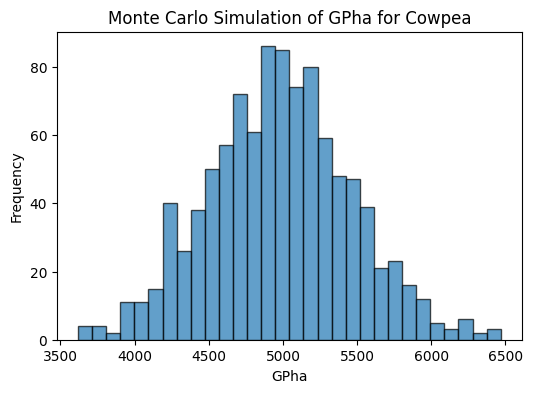

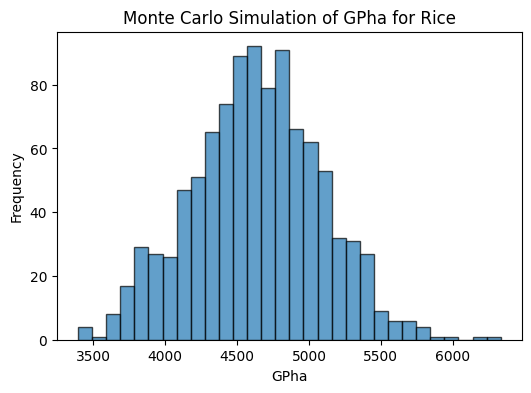

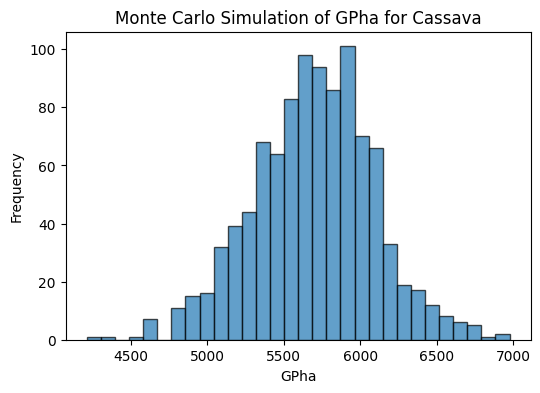

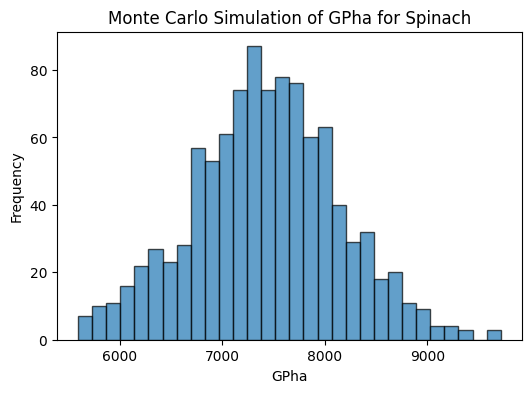

In [28]:
for crop in crops:
    plt.figure(figsize=(6,4))
    plt.hist(sim_gp[crop], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Monte Carlo Simulation of GPha for {crop}')
    plt.xlabel('GPha')
    plt.ylabel('Frequency')
    plt.show()

expected_gp = {crop: np.mean(values) for crop, values in sim_gp.items()}

#Optimization

In [29]:
VC = {'Maize': 1700, 'Cowpea': 2400, 'Rice': 950, 'Cassava': 1300, 'Spinach': 1900} #Variable cost per hectare (MAD)
WR = {'Maize': 3500, 'Cowpea': 4500, 'Rice': 4200, 'Cassava': 3200, 'Spinach': 7500} #Water required per hectare (m³)
TotLand = 22  #Total land available
Budget = 52000  #Max money available for input costs
Waterend = 110000  #Max irrigation water available

c = [-expected_gp[c] for c in crops]
A_ub = [
    [1, 1, 1, 1, 1],
    [VC[c] for c in crops],
    [WR[c] for c in crops],
    [1, 1, -1, -1, -1]
]
b_ub = [TotLand, Budget, Waterend, 0]
bounds = [(0, None)] * len(crops)

res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

expected_gp = pd.Series(expected_gp)
optimal_area = pd.Series(res.x, index=crops)
result_summary = pd.DataFrame({
    'Expected_GPha': expected_gp.round(2),
    'Area_Allocated': optimal_area.round(2),
    'Total_Contribution': (expected_gp * optimal_area).round(2)
})
result_summary.loc['Total'] = result_summary.sum()

#Visualization

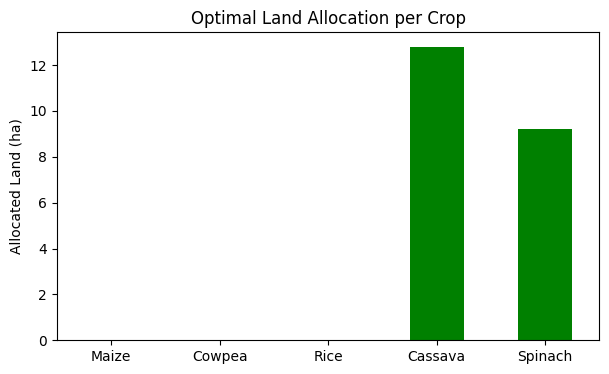

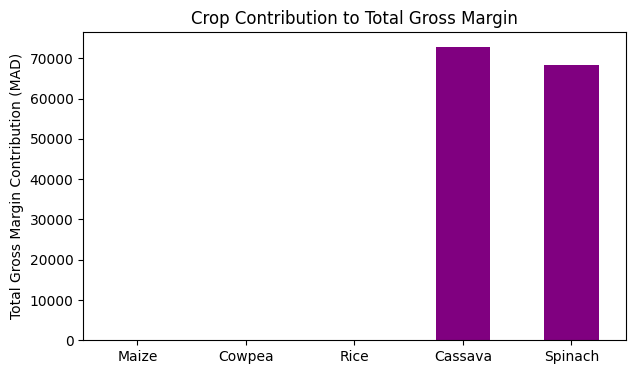

In [30]:
#Optimal Land Allocation
optimal_area.plot(kind='bar', color='green', figsize=(7,4))
plt.xticks(rotation=0)
plt.ylabel('Allocated Land (ha)')
plt.title('Optimal Land Allocation per Crop')
plt.show()

#Visualization:Total Contribution to Gross Margin
result_summary.iloc[:-1]['Total_Contribution'].plot(kind='bar', color='purple', figsize=(7,4))
plt.xticks(rotation=0)
plt.ylabel('Total Gross Margin Contribution (MAD)')
plt.title('Crop Contribution to Total Gross Margin')
plt.show()


#Final Summary Output

In [31]:
print(result_summary)
print("\nTotal Expected Gross Margin:", round(-res.fun, 2))

         Expected_GPha  Area_Allocated  Total_Contribution
Maize          4255.83            0.00                0.00
Cowpea         4974.15            0.00                0.00
Rice           4637.36            0.00                0.00
Cassava        5692.75           12.79            72814.28
Spinach        7427.37            9.21            68400.89
Total         26987.46           22.00           141215.17

Total Expected Gross Margin: 141215.17
